## Eval Module

In [33]:
import pandas as pd
import sqlalchemy
import os, sys, copy, random, pickle, cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append("../")

%load_ext autoreload
%autoreload 2

from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.Interproc import DBInterface, GuiviewState

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, presetCubeViews, bytesToPic, bytesToPic2,
         croppedPic, colorInRange, imgToColors, pointsToList,
         roiSelectZoomWindow, roiSelectScoreWindow, subprocBatchOutput,
         exploreImgs, buildImgComparisonData, subprocEval)

from modules.EvalHelpers import EvalTracker, EvalDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sqlalchemy

In [14]:
engine = sqlalchemy.create_engine('sqlite:///../data/usr/eval_tmp.db')

In [19]:
interproc_df = pd.read_sql_table('current_dataframe', con=engine)

In [21]:
interproc_df[:5]

,index,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline
0,0,True,True,True,True,True,True,-7.0,5.385165
1,1,None,None,None,None,None,True,NaN,NaN
2,2,None,None,None,None,None,True,NaN,NaN
3,3,None,None,None,None,None,True,NaN,NaN
4,4,None,None,None,None,None,True,NaN,NaN


In [23]:
from modules.AnalysisHelpers import subprocEval

In [34]:
vid_fn = 'data/proc/raw/oct20/output4.avi'
algos = [0,1,2]

eval_data = []
for _algo in algos:
    
    eval_data.append(subprocEval(vid_fn, algo_enum = _algo))
    
for _df in eval_data:
    print 'length of %i' % len(_df[_df.checkTrackSuccess == False])

length of 28
length of 28
length of 10


In [35]:
mydf = eval_data[2]

In [36]:
from modules.EvalHelpers import EvalDataset

In [39]:
my_evdata = EvalDataset()

In [40]:
my_evdata.setDf(mydf.copy())

In [42]:
tmp_df = my_evdata.getDataset()

In [44]:
condition_1 = (tmp_df.checkTrackSuccess == False)

In [45]:
condition_1.shape

(386,)

In [46]:
my_evdata.setRowsRequested(condition_1)

In [50]:
condition_1[0]

False

In [51]:
frames = [i for i,v in enumerate(condition_1) if v]

In [52]:
frames

[142, 144, 152, 153, 154, 155, 157, 159, 160, 161]

In [53]:
listGS = subprocBatchOutput(vid_fn, batch_list = frames )
[_gs.frameCounter for _gs in listGS]

[142, 144, 152, 153, 154, 155, 157, 159, 160, 161]

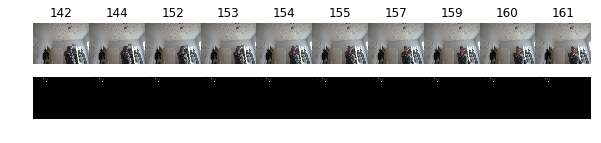

In [54]:
exploreImgs(listGS[:10], figw=10)

In [31]:
print 'length of %i' % len(df4[df4.checkTrackSuccess == False])
df4[df4.checkTrackSuccess == False][:4]

length of 28


,index,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline
142,142,False,False,False,False,False,False,None,9999.9
144,144,False,False,False,False,False,False,None,9999.9
152,152,False,False,False,False,False,False,None,9999.9
153,153,False,False,False,False,False,False,None,9999.9


In [5]:
engine = sqlalchemy.create_engine('sqlite://', echo=True)

In [6]:
engine2 = sqlalchemy.create_engine('sqlite:///tmp.db', echo=True)

In [9]:
df.to_sql('myname', con=engine2 )

2018-12-28 18:26:56,349 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-12-28 18:26:56,351 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:26:56,355 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-12-28 18:26:56,357 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:26:56,358 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("myname")
2018-12-28 18:26:56,361 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:26:56,369 INFO sqlalchemy.engine.base.Engine 
CREATE TABLE myname (
	"index" BIGINT, 
	"checkBaselineInsideTrack" BOOLEAN, 
	"checkBothContainsOther" BOOLEAN, 
	"checkEitherContainsOther" BOOLEAN, 
	"checkTrackInsideBaseline" BOOLEAN, 
	"checkTrackInsideBaselineRect" BOOLEAN, 
	"checkTrackSuccess" BOOLEAN, 
	"compareRadii" BIGINT, 
	"distanceFromBaseline" FLOAT, 
	"frameCounter" BIGINT, 
	"listIndex" BIGINT, 
	CHECK ("checkBaselineInsideTrack" IN (0, 1)), 
	CHECK ("check

In [10]:
engine3 = sqlalchemy.create_engine('sqlite:///tmp.db', echo=True)

In [12]:
newdf = pd.read_sql_table('myname', con=engine3)

2018-12-28 18:29:21,338 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2018-12-28 18:29:21,339 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,342 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2018-12-28 18:29:21,342 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,345 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2018-12-28 18:29:21,349 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,357 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='view' ORDER BY name
2018-12-28 18:29:21,358 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,361 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("myname")
2018-12-28 18:29:21,362 INFO sqlalchemy.engine.base.Engine ()
2018-12-28 18:29:21,369 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SEL

In [13]:
newdf

,index,checkBaselineInsideTrack,checkBothContainsOther,checkEitherContainsOther,checkTrackInsideBaseline,checkTrackInsideBaselineRect,checkTrackSuccess,compareRadii,distanceFromBaseline,frameCounter,listIndex
0,0,True,True,True,True,False,True,6,2.236068,0,0
1,1,True,True,True,True,False,True,7,7.211103,9,1
2,2,True,True,True,True,False,True,-1,1.414214,78,2
3,3,True,True,True,True,False,True,3,4.472136,116,3
4,4,True,True,True,True,False,True,2,4.123106,136,4
5,5,True,True,True,True,False,True,0,5.385165,176,5
6,6,False,False,False,False,False,True,-1,5.385165,187,6
7,7,False,False,False,False,False,True,-2,6.000000,194,7
8,8,False,False,False,False,False,True,-1,4.000000,195,8
9,9,False,False,False,False,False,True,-3,4.123106,201,9


In [ ]:
DBInterface

In [7]:
db_name = "../data/misc/books/eval-data-2/large_dataset.db"
db = DBInterface(db_name)
listGS = [ pickle.loads(d[1]) for d in db.selectAll()]
tracker = TrackFactory(on=True)
tracker.setInit(ballColor = "orange")
tracker.setAlgoEnum(1)
evData = EvalDataset()
evData.buildDataset(listGS, tracker)
df = evData.getDataset()